In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.axis('off')
  plt.show()

import tensorflow as tf
flags = tf.app.flags
#import gflags as flags
FLAGS = flags.FLAGS

#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/', '')
  
import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import algos_factory
from deepiu.seq2seq.rnn_decoder import SeqDecodeMethod

#debug
from deepiu.util import text2ids

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_checkpoint_file = '/home/gezi/data/image_model_check_point/inception_v4.ckpt'
net = melt.image.get_imagenet_from_checkpoint(image_checkpoint_file)
print('image net', net, 'net.default_image_size', net.default_image_size)
FLAGS.image_model_name = FLAGS.image_model_name or net.name
FLAGS.image_height = FLAGS.image_height or net.default_image_size
FLAGS.image_width = FLAGS.image_width or net.default_image_size
image_model_name = FLAGS.image_model_name
print('image_model_name', image_model_name)

model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v5/showattentell.luong.fromimg.inceptionV4/'

#FLAGS.model_dir = model_dir

if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path)
else:
  image_model = None

print('image_model', image_model)

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.4.1


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words
image net <function inception_v4 at 0x7fa1256bc7d0> net.default_image_size 299
image_model_name InceptionV4


ENCODE_UNK 1


image_model None


In [2]:
if 'coverage' in model_dir:
  FLAGS.coverage_attention_wrapper = True

FLAGS.image_encoder = 'Rnn'
FLAGS.showtell_encode_scope = 'encode'
FLAGS.showtell_decode_scope = 'decode'
FLAGS.image_endpoint_feature_name = 'attention'
FLAGS.image_checkpoint_file = image_checkpoint_file
FLAGS.pre_calc_image_feature = False
FLAGS.finetune_image_model = True 
FLAGS.image_features_batch_norm = True 
FLAGS.emb_dim = 512 
FLAGS.rnn_hidden_size = 512 
FLAGS.alignment_history = True

FLAGS.image_attention_size = FLAGS.image_attention_size or melt.image.get_num_features(FLAGS.image_model_name)
FLAGS.image_feature_len = FLAGS.image_feature_len or melt.image.get_feature_dim(FLAGS.image_model_name) * FLAGS.image_attention_size

beam_size = 10
length_normalization_factor = 0.25

In [3]:
# algo = 'show_and_tell'
# global_scope = algo
# main_scope = 'main'
# melt.apps.image_processing.init(FLAGS.image_model_name)
# with tf.variable_scope(global_scope):
#   with tf.variable_scope(main_scope):
#     predictor =  algos_factory.gen_predictor(algo)
#     predictor.init_predict_text(decode_method=SeqDecodeMethod.ingraph_beam, 
#                                 beam_size=beam_size,
#                                 length_normalization_factor=length_normalization_factor,
#                                 logprobs_history=True,
#                                 alignment_history=True)  

# predictor.load(FLAGS.model_dir) 

In [4]:
predictor = melt.Predictor(model_dir)

class Predictor(object):
  def __init__(self, predictor):
    self._predictor = predictor
    self._sess = sess = predictor.sess
    self._graph = graph = predictor.graph
    self._ops = [graph.get_collection(x)[-1] for x in ['beam_text', 'beam_text_score', 'beam_logprobs_history', 'beam_alignment_history']]
  def predict_text(self, feature):
    return self._sess.run(self._ops, feed_dict={self._graph.get_collection('feed')[-1]: feature})
  
predictor = Predictor(predictor)

load frozen graph from /home/gezi/new/temp/image-caption/ai-challenger/model.v5/showattentell.luong.fromimg.inceptionV4/model.ckpt-3.63-119000.pb with mapfile /home/gezi/new/temp/image-caption/ai-challenger/model.v5/showattentell.luong.fromimg.inceptionV4/model.ckpt-3.63-119000.map start
load frozen graph from /home/gezi/new/temp/image-caption/ai-challenger/model.v5/showattentell.luong.fromimg.inceptionV4/model.ckpt-3.63-119000.pb with mapfile /home/gezi/new/temp/image-caption/ai-challenger/model.v5/showattentell.luong.fromimg.inceptionV4/model.ckpt-3.63-119000.map duration: 14.6099200249


In [5]:
def simple_predict(image_path, predictor):
  timer = gezi.Timer('beam search using time')
  img = melt.read_image(image_path)
  if image_model:
    #attention model gen features only
    feature = image_model.gen_features(img) if image_model is not None else img
  else:
    feature = [img]    
  #texts_list, scores_list = predictor.predict_text(feature)
  #timer.print()
  logprobs_history = None 
  alignment_history = None

  l = predictor.predict_text(feature)
  timer.print()
  texts_list, scores_list= l[0], l[1]
  try:
    logprobs_history = l[2]
    alignment_history = l[3]
  except Exception:
    pass

  #print(alignment_history)

  texts = texts_list[0]
  scores = scores_list[0]
  if logprobs_history is not None:
    logprobs = logprobs_history[0]
  else:
    logprobs = [None] * len(texts)
  if alignment_history is not None:
    alignments = alignment_history[0]
  else:
    alignments = [None] * len(texts)
    
  logprob = None 
  alignment = None 
    
  for text, score, logprob, alignment in zip(texts, scores, logprobs, alignments):
    print('align shape', alignment.shape)
    print(ids2text.ids2text(text), score)
    print(text, len(text))
    if logprob is not None:
      print(map(math.exp, logprob))
    #if alignment is not None:
    #  print(alignment)
    #  print(alignment[10], alignment[11], alignment[12])


In [6]:
#simple_predict(image_path, predictor)

In [7]:
def predict(image_path, predictor, length_normalization_factor=0.25, num_show=1):
  img = melt.read_image(image_path)
  if image_model:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]

  timer = gezi.Timer()
  texts, scores, logprobs_history, alignment_history = predictor.predict_text(feature)
  for i, (text, score, logprob, alignment) in enumerate(zip(texts[0], scores[0], logprobs_history[0], alignment_history[0])):
    print(ids2text.ids2text(text), score)

    # Plot images with attention weights
    words = ids2text.ids2words(text) 
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    #print(n_words, w, h)
            
    IMAGE_SIZE = (14, 10)
    plt.figure(figsize=IMAGE_SIZE)
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 10:  
      #print('probs', [math.exp(x) for x in logprob])
      for j in range(len(words)):
        #if i == 0:
        #  print(i, j, words[j], alignment[j])
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(words[j].decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(logprob[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(alignment[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(alignment[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

    print('beam search using time(ms):', timer.elapsed_ms())

In [ ]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:100000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 6d36d83e50bfd4739c5e80027bb6e70dea643dd9


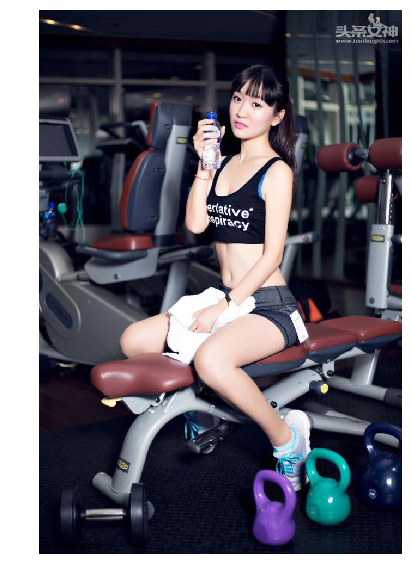

健身房 里 有 一个 右手 拿 着 手机 的 女人 坐在 摩托车 上 </S> 0.033324


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


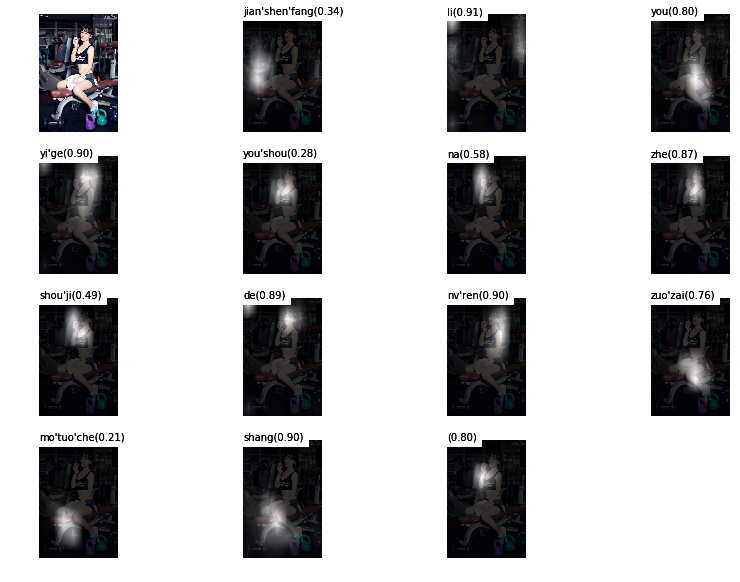

beam search using time(ms): 11388.0629539
一个 右手 拿 着 手机 的 女人 坐在 健身房 里 </S> 0.0223425


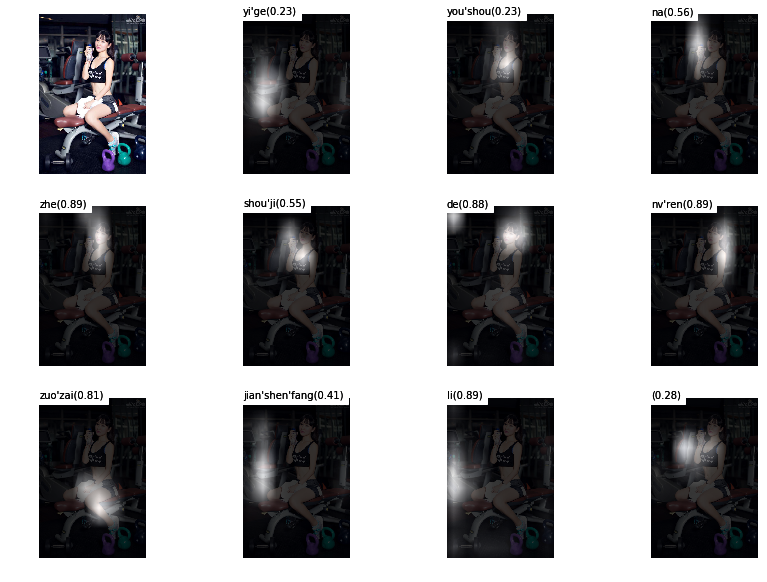

beam search using time(ms): 2005.70106506
健身房 里 有 一个 左手 拿 着 手机 的 女人 坐在 摩托车 上 </S> 0.0215952


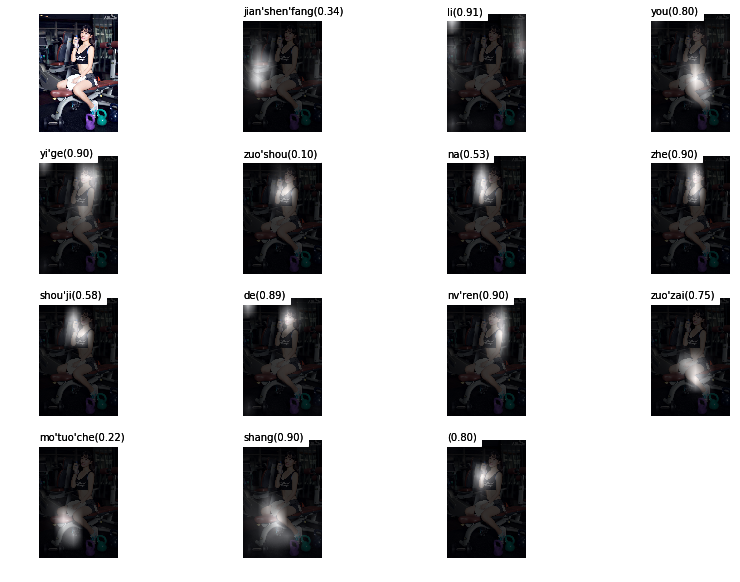

beam search using time(ms): 1794.01779175
健身房 里 有 一个 右手 拿 着 手机 的 女人 坐在 玩具车 上 </S> 0.0178209


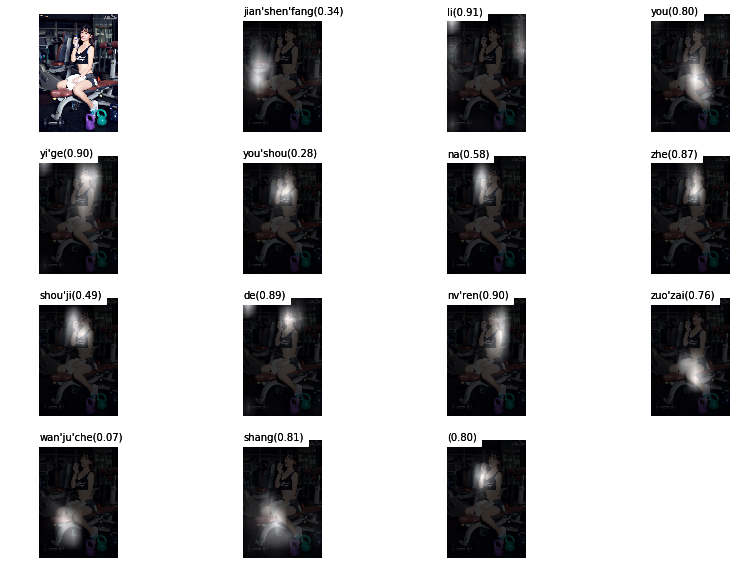

beam search using time(ms): 2631.77418709
健身房 里 有 一个 右手 拿 着 手机 的 女人 在 自拍 </S> 0.0157945


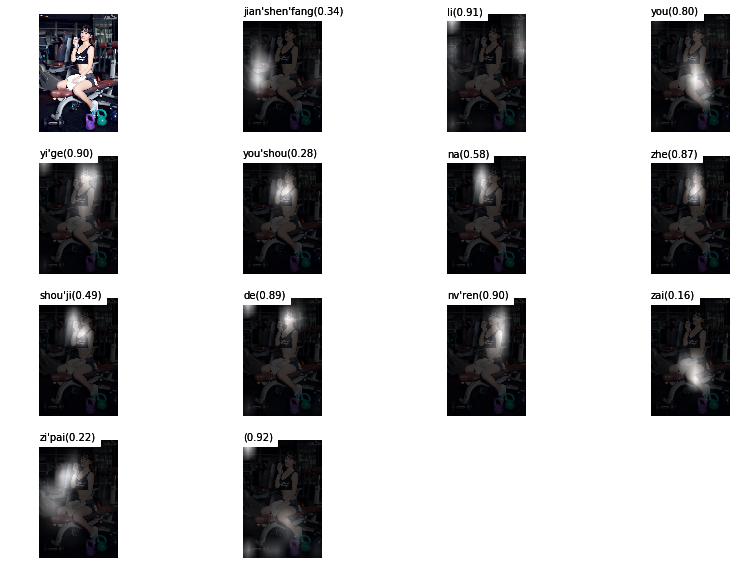

beam search using time(ms): 1754.03499603
健身房 里 有 一个 右手 拿 着 手机 的 女人 在 拍照 </S> 0.0138795


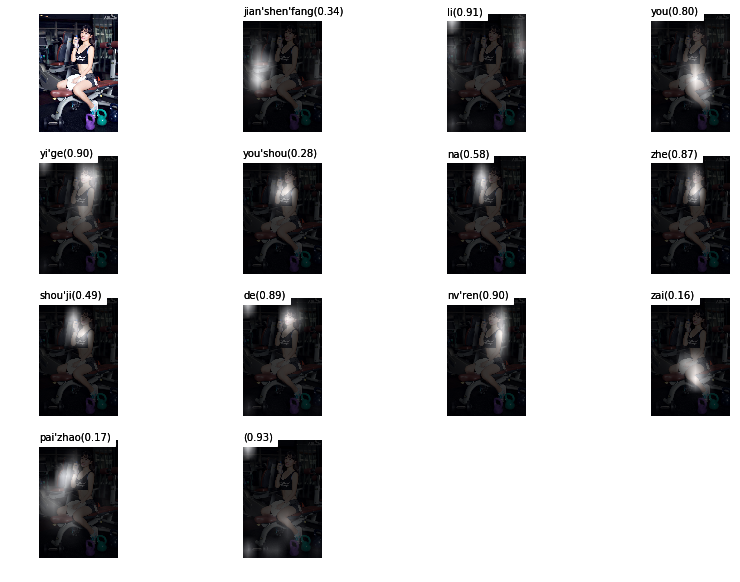

beam search using time(ms): 1765.7148838
健身房 里 有 一个 右手 拿 着 手机 的 女人 坐在 椅子 上 </S> 0.0133872


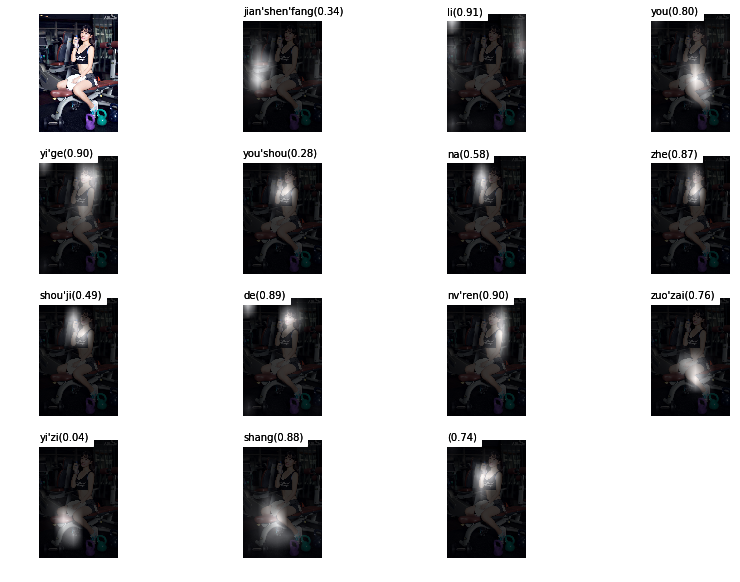

beam search using time(ms): 1879.20713425
一个 左手 拿 着 手机 的 女人 坐在 健身房 里 </S> 0.0123676


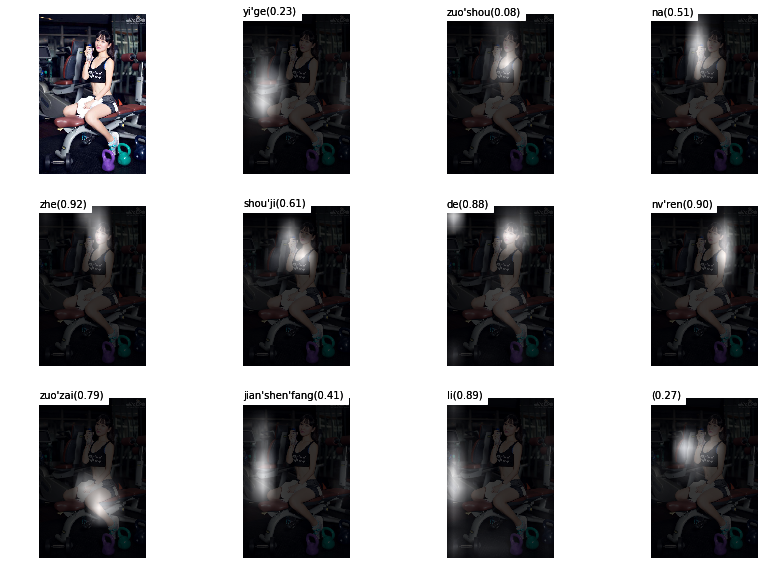

beam search using time(ms): 1520.33090591
健身房 里 有 一个 左手 拿 着 手机 的 女人 坐在 玩具车 上 </S> 0.0111827


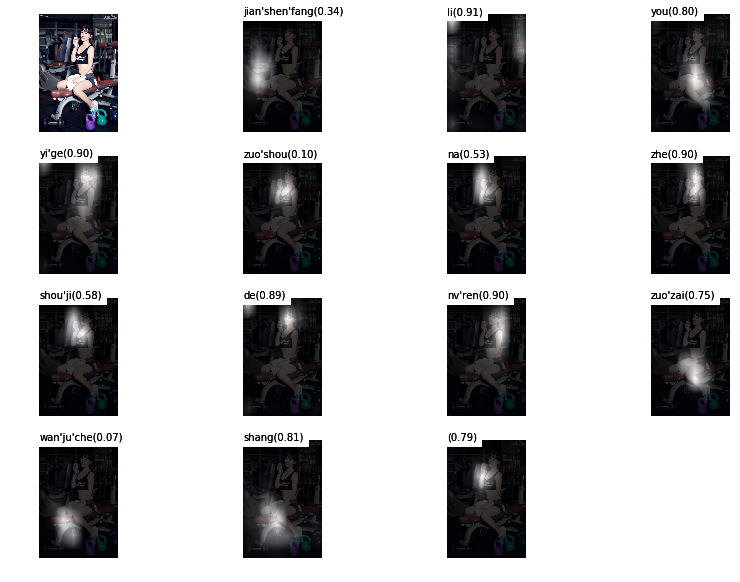

beam search using time(ms): 1853.70588303
健身房 里 有 一个 右手 拿 着 手机 的 女人 坐在 地上 </S> 0.0101582


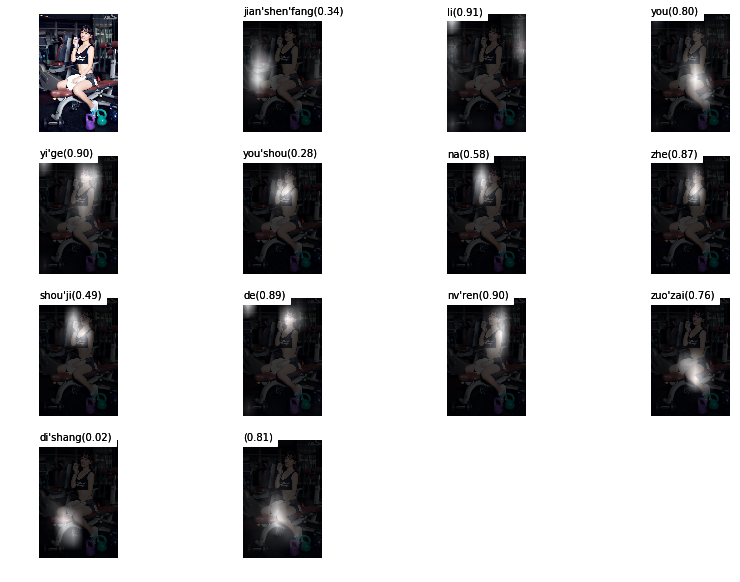

beam search using time(ms): 1804.79216576


In [ ]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: ')
  image_name = image_name.strip().replace('file://', '')
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'

  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    image_path = image_name
    if not os.path.exists(image_path):
        continue
  #plt.subplot(1, 1, 1)
  #image_show(image_path)
  IMAGE_SIZE = (14, 10)
  #plt.subplot(1, 1, 1)  
  plt.figure(figsize=IMAGE_SIZE)
  image_show(image_path)

  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)

In [ ]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)